In [ ]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv \
    -O /tmp/daily-min-temperatures.csv

--2024-01-13 09:17:44--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67921 (66K) [text/plain]
Saving to: ‘/tmp/daily-min-temperatures.csv’

/tmp/daily-min-temp 100%[===================>]  66.33K  --.-KB/s    in 0.01s   

2024-01-13 09:17:44 (5.32 MB/s) - ‘/tmp/daily-min-temperatures.csv’ saved [67921/67921]



In [ ]:
import pandas as pd
df = pd.read_csv('/tmp/daily-min-temperatures.csv', encoding= 'unicode_escape')
df.head()

Date  Temp
0  1981-01-01  20.7
1  1981-01-02  17.9
2  1981-01-03  18.8
3  1981-01-04  14.6
4  1981-01-05  15.8

In [14]:
df

Date  Temp
0     1981-01-01  20.7
1     1981-01-02  17.9
2     1981-01-03  18.8
3     1981-01-04  14.6
4     1981-01-05  15.8
...          ...   ...
3645  1990-12-27  14.0
3646  1990-12-28  13.6
3647  1990-12-29  13.5
3648  1990-12-30  15.7
3649  1990-12-31  13.0

[3650 rows x 2 columns]

In [ ]:
df.isnull().sum()

Date    0
Temp    0
dtype: int64

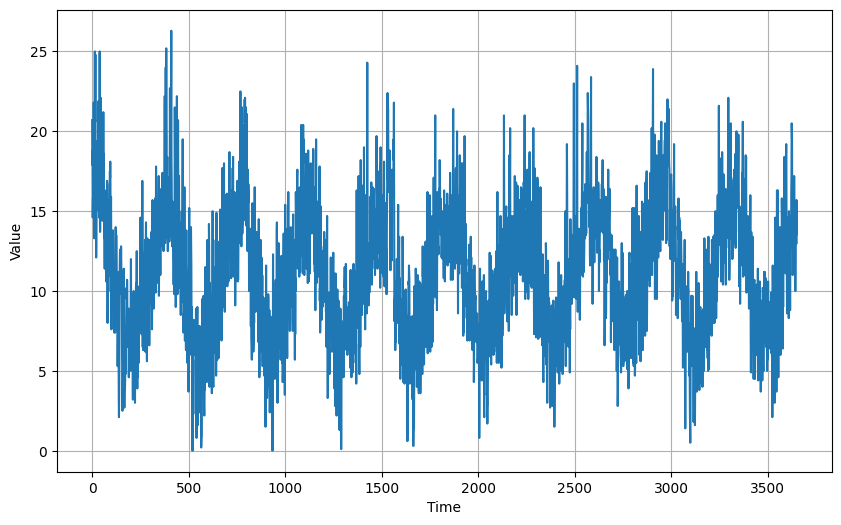

In [ ]:
import numpy as np
import csv
import matplotlib.pyplot as plt

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

time_step = []
temps = []
x=0
with open('/tmp/daily-min-temperatures.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for row in reader:
    temps.append(float(row[1]))
    time_step.append(x)
    x=x+1

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(series, time, train_size=0.8, test_size = 0.2, shuffle = False )

In [ ]:
split_time = 2500
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [ ]:
Mae = (df['Temp'].max() - df['Temp'].min()) * 10/100
print(Mae)

2.63


In [ ]:
import tensorflow as tf
from keras.optimizers import SGD

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(60, return_sequences=True),
    tf.keras.layers.LSTM(60),
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1),
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


Epoch 1/100
10/10 [==============================] - 6s 24ms/step - loss: 10.0710 - mae: 10.5696 - lr: 1.0000e-08
Epoch 2/100
10/10 [==============================] - 0s 29ms/step - loss: 10.0710 - mae: 10.5696 - lr: 1.1220e-08
Epoch 3/100
10/10 [==============================] - 0s 30ms/step - loss: 10.0710 - mae: 10.5696 - lr: 1.2589e-08
Epoch 4/100
10/10 [==============================] - 0s 31ms/step - loss: 10.0709 - mae: 10.5696 - lr: 1.4125e-08
Epoch 5/100
10/10 [==============================] - 0s 30ms/step - loss: 10.0709 - mae: 10.5696 - lr: 1.5849e-08
Epoch 6/100
10/10 [==============================] - 0s 28ms/step - loss: 10.0709 - mae: 10.5695 - lr: 1.7783e-08
Epoch 7/100
10/10 [==============================] - 0s 30ms/step - loss: 10.0709 - mae: 10.5695 - lr: 1.9953e-08
Epoch 8/100
10/10 [==============================] - 0s 30ms/step - loss: 10.0708 - mae: 10.5695 - lr: 2.2387e-08
Epoch 9/100
10/10 [==============================] - 0s 29ms/step - loss: 10.0708 - mae:

```
Nama : Rahmat Pratami
Email : exzaardyansyah894@gmail.com
```

